In [1]:
import numpy as np
from numpy.linalg import eig
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator
from qiskit_aer import AerSimulator

Based on the following Qiskit tutorial: https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

# Let's define the operator:

In [2]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [3]:
H = hamiltonian.to_matrix()
print(H)

[[-0.4093+0.j     0.    +0.j     0.    -0.398j  0.181 +0.j   ]
 [ 0.    +0.j    -0.3867+0.j     0.181 +0.j     0.    +0.398j]
 [ 0.    +0.398j  0.181 +0.j     0.4093+0.j     0.    +0.j   ]
 [ 0.181 +0.j     0.    -0.398j  0.    +0.j     0.3867+0.j   ]]


In [4]:
hamiltonian_operator = Operator(hamiltonian)
hamiltonian_operator.draw(output='latex')

<IPython.core.display.Latex object>

# Let's find eigenvalues using classical numpy linear algebra package:

In [5]:
e,v=eig(H)
print("Eigenvalues:", e)
print("Eigenvectors:\n", v)

Eigenvalues: [-0.70293039+6.24707871e-18j -0.45308083-7.57079461e-17j
  0.70293039-6.06797210e-18j  0.45308083+3.47628378e-17j]
Eigenvectors:
 [[ 6.49638715e-01+0.00000000e+00j -1.13885050e-18+6.65864932e-01j
   7.01111754e-18-3.30320834e-01j -1.59629506e-01-4.32331142e-17j]
 [-2.91446790e-16+6.01307531e-01j  7.03606721e-01+0.00000000e+00j
   3.27546851e-01-2.90500924e-17j -2.28717515e-17+1.89947086e-01j]
 [-3.02255009e-17-3.30320834e-01j  1.59629506e-01+8.31587415e-17j
   6.49638715e-01+0.00000000e+00j  1.18760305e-16-6.65864932e-01j]
 [-3.27546851e-01-1.37383111e-16j -1.35473761e-17+1.89947086e-01j
  -1.69472202e-17-6.01307531e-01j  7.03606721e-01+0.00000000e+00j]]


# ...or even find smallest eigenvalue with Qiskit wrapper over classical numpy eigensolver:

In [6]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
minimal_eigenvalue = result.eigenvalue.real
print(minimal_eigenvalue)

-0.702930394459531


# Now, let's use VQE algorithm

In [7]:
ansatz = TwoLocal(hamiltonian.num_qubits, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

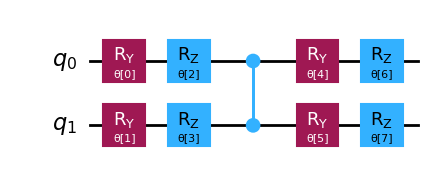

In [8]:
ansatz.decompose().draw("mpl")

In [9]:
num_params = ansatz.num_parameters
print(num_params)

8


In [10]:
print(hamiltonian.num_qubits)

2


In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    costs.append(energy)
    print(f"Iteration: {len(costs)+1}, cost: {energy}")

    return energy

In [12]:
costs = []

In [13]:
x0 = 2 * np.pi * np.random.random(num_params)
print(x0)

[1.36474905 4.88878073 5.42653557 4.90873798 6.11350593 3.76470593
 0.7910529  0.91621414]


### Simplest approach is to use StatevectorEstimator:

In [14]:
estimator = StatevectorEstimator()

res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
)

Iteration: 2, cost: 0.30575321414196566
Iteration: 3, cost: 0.30527717944132615
Iteration: 4, cost: 0.46041326655905346
Iteration: 5, cost: 0.22584660015558455
Iteration: 6, cost: 0.1086252121178325
Iteration: 7, cost: 0.13614030272233785
Iteration: 8, cost: -0.28916145521705855
Iteration: 9, cost: -0.23561850909471893
Iteration: 10, cost: -0.3739650186877702
Iteration: 11, cost: -0.5454771979938375
Iteration: 12, cost: -0.5881586850808229
Iteration: 13, cost: -0.5394234909422333
Iteration: 14, cost: -0.45187918985619
Iteration: 15, cost: -0.6084279635910611
Iteration: 16, cost: -0.5260240971805477
Iteration: 17, cost: -0.5847447708911495
Iteration: 18, cost: -0.5624940270660306
Iteration: 19, cost: -0.5630495727943482
Iteration: 20, cost: -0.582658505878631
Iteration: 21, cost: -0.6474668077928523
Iteration: 22, cost: -0.6391518987348135
Iteration: 23, cost: -0.6106460595660542
Iteration: 24, cost: -0.6412210874049662
Iteration: 25, cost: -0.6201826603366959
Iteration: 26, cost: -0.60

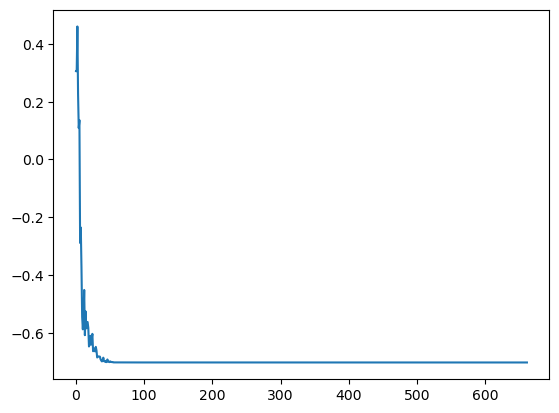

In [15]:
import matplotlib.pyplot as plt

plt.plot(costs)

### But we can also use AerSimulator, which works more like real backends:

In [20]:
costs = []

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)


with Session(backend=aer_sim) as session:
    estimator = Estimator()
    estimator.options.default_shots = 10000
    
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iteration: 2, cost: 0.31155102
Iteration: 3, cost: 0.30564682000000004
Iteration: 4, cost: 0.4643217999999999
Iteration: 5, cost: 0.22551785999999996
Iteration: 6, cost: 0.10749679999999995
Iteration: 7, cost: 0.13828058
Iteration: 8, cost: -0.28264108
Iteration: 9, cost: -0.24755497999999998
Iteration: 10, cost: -0.37424157999999996
Iteration: 11, cost: -0.5475903800000002
Iteration: 12, cost: -0.5945086800000001
Iteration: 13, cost: -0.5239189000000001
Iteration: 14, cost: -0.44635855999999996
Iteration: 15, cost: -0.6005988800000001
Iteration: 16, cost: -0.54431226
Iteration: 17, cost: -0.58652386
Iteration: 18, cost: -0.5632881200000001
Iteration: 19, cost: -0.5346678200000001
Iteration: 20, cost: -0.5902922800000001
Iteration: 21, cost: -0.66456328
Iteration: 22, cost: -0.6307764400000001
Iteration: 23, cost: -0.6393036200000001
Iteration: 24, cost: -0.66051706
Iteration: 25, cost: -0.65144082
Iteration: 26, cost: -0.67184762
Iteration: 27, cost: -0.6662049600000001
Iteration: 28,

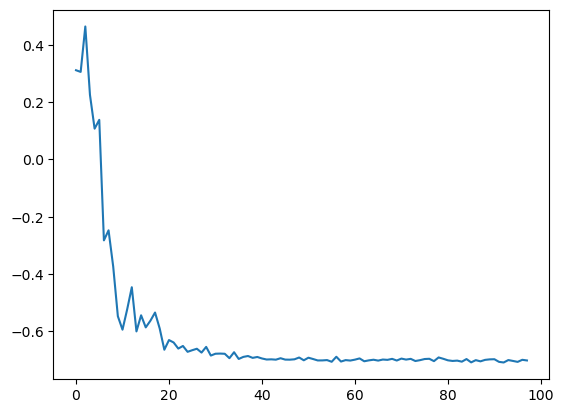

In [21]:
import matplotlib.pyplot as plt

plt.plot(costs)